## 1. Training SAC

In [1]:
# Clean any conflicting versions
!pip uninstall -y gym gymnasium box2d box2d-py stable-baselines3 pygame tensorboard

# Install core dependencies
!apt-get install -y swig
!pip install numpy==1.23.5
!pip install gymnasium[box2d]==0.28.1 pygame==2.1.3 imageio stable-baselines3==2.3.2

import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecFrameStack
import numpy as np
import imageio
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt

Found existing installation: gymnasium 0.28.1
Uninstalling gymnasium-0.28.1:
  Successfully uninstalled gymnasium-0.28.1
Found existing installation: box2d-py 2.3.5
Uninstalling box2d-py-2.3.5:
  Successfully uninstalled box2d-py-2.3.5
Found existing installation: stable_baselines3 2.3.2
Uninstalling stable_baselines3-2.3.2:
  Successfully uninstalled stable_baselines3-2.3.2
Found existing installation: pygame 2.1.3
Uninstalling pygame-2.1.3:
  Successfully uninstalled pygame-2.1.3
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
  Using cached gymnasium-0.28.1-py3-none-any.whl.metadata (9.2 kB)
  Using cached pygame-2.1.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.3 kB)
  Using cached stable_baselines3-2.3.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached box2d_py-2.3.5-cp311-cp311-linux_x86_6

In [ ]:
# Model training

# -------Training parameters---------

timesteps = 100000
learning_rate=3e-4
buffer_size = 1000000
batch_size = 256
gamma = 0.99
learning_starts = 5000
stacked_frames = 4

#--------- Rewards --------------------

class RewardShapingWrapper(gym.Wrapper):
    def __init__(self, env):
        super(RewardShapingWrapper, self).__init__(env)

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # reward shaping
        if reward < 0:
            reward = -1  # strong penalty for off-track

        # bonus for high speed
        speed = np.linalg.norm(info.get("velocity", [0, 0]))
        reward += 0.55 * speed

        # clip reward between -1, 1
        reward = np.clip(reward, -1, 1)


        return obs, reward, terminated, truncated, info


# --------- Environment ------------------

env = DummyVecEnv([lambda: RewardShapingWrapper(gym.make("CarRacing-v2", render_mode="rgb_array"))])
#env = DummyVecEnv([lambda: gym.make("CarRacing-v2", render_mode="rgb_array")])

# stack frames (learn with motion)
# env = VecFrameStack(env, n_stack=stacked_frames)

# --------- Model training ----------------

model = SAC("CnnPolicy", env,
    learning_rate=learning_rate,
    buffer_size=buffer_size,
    batch_size=batch_size,
    learning_starts=learning_starts,
    tau=0.005,
    gamma=gamma,
    train_freq=(1, "step"),
    gradient_steps=1,
    ent_coef="auto",
    verbose=2)

# EvalCallback

# Use a monitored eval environment
eval_env = Monitor(gym.make("CarRacing-v2", render_mode="rgb_array"))

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs/",
    log_path="./logs/",
    eval_freq=5000,            # evaluate every 5k steps
    n_eval_episodes=3,         # average over 3 episodes
    deterministic=True,
    render=False
)

model.learn(total_timesteps=timesteps, callback=eval_callback)
model.save("sac_carracing")

# ----------- Validation environment -----------------------

eval_env = gym.make("CarRacing-v2", render_mode="rgb_array")
obs, _ = eval_env.reset()
done = False
frames = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = eval_env.step(action)
    frame = eval_env.render()
    frames.append(frame)
    done = terminated or truncated

eval_env.close()


# ------------ Plots/Videos --------------------------------

# Load evaluation log and plot
try:
    # Load evaluation results
    data = np.load("./logs/evaluations.npz")

    timesteps = data["timesteps"]
    mean_rewards = data["results"].mean(axis=1)  # average over n_eval_episodes


    plt.plot(timesteps, mean_rewards)
    plt.xlabel("Timesteps")
    plt.ylabel("Mean Evaluation Reward")
    plt.title("SAC Evaluation Rewards Over Time")
    plt.grid()
    plt.show()
except Exception as e:
    print("Plotting failed:", e)

# Save the video
video_path = "/content/carracing_sac.mp4"
imageio.mimsave(video_path, [np.array(f) for f in frames], fps=30)

# Download the video
#files.download(video_path)

Using cuda device
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 55.32GB > 10.35GB
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7862052752d0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7861f5dedd50>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


-----------------------------
| time/              |      |
|    episodes        | 4    |
|    fps             | 87   |
|    time_elapsed    | 45   |
|    total_timesteps | 4000 |
-----------------------------
Eval num_timesteps=5000, episode_reward=-17.55 +/- 17.76
Episode length: 1000.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -17.6    |
| time/              |          |
|    total_timesteps | 5000     |
---------------------------------
New best mean reward!
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 32       |
|    time_elapsed    | 243      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -4.93    |
|    critic_loss     | 0.452    |
|    ent_coef        | 0.407    |
|    ent_coef_loss   | -4.54    |
|    learning_rate   | 0.0003   |
|    n_updates       | 2999     

## 2. Test model on Montmeló Circuit

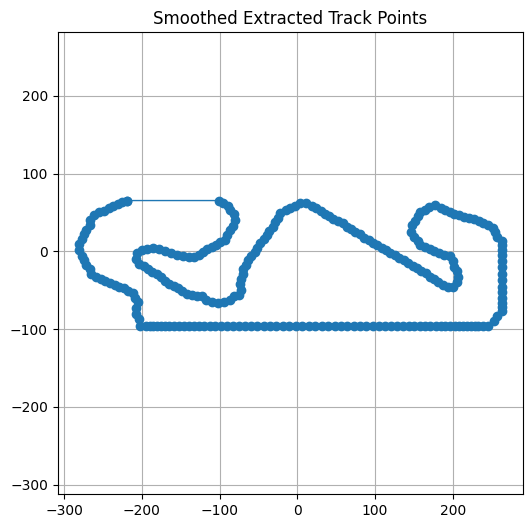

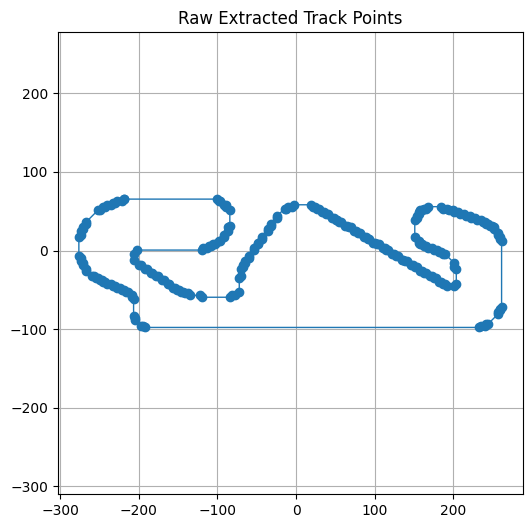

In [ ]:
# create circuit

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import pickle


# Load your image (grayscale)
image_path = "montmelo.png"  # png file
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Invert and threshold to isolate the track shape
_, thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Use the largest contour
track_contour = max(contours, key=cv2.contourArea).squeeze()

# Downsample the contour to reduce complexity
track_contour = track_contour[::1]  # take every th point

# Convert to float and center it around (0, 0)
track_contour = track_contour.astype(np.float32)
track_contour -= track_contour.mean(axis=0)

# Rescale
contour_scaler = 1.2 # MAX 1.2 !!
track_contour /= (0.5/contour_scaler)

# Invert Y-axis
track_contour[:, 1] *= -1  # flip y values

# -------- smoothed -----------------------------------------
from scipy.interpolate import splprep, splev

x, y = track_contour[:, 0], track_contour[:, 1]
tck, u = splprep([x, y], s=0.01)
unew = np.linspace(0, 1.0, len(x))
x_smooth, y_smooth = splev(unew, tck)
track_contour2 = np.stack([x_smooth, y_smooth], axis=1).astype(np.float32)

# Ensure closed loop
if not np.array_equal(track_contour2[0], track_contour2[-1]):
    track_contour2 = np.vstack([track_contour2, track_contour2[0]])

# Fix horizontal straight (bottom)
lowest_y = np.percentile(track_contour2[:, 1], 25)
horizontal_straight_idx = np.where(track_contour2[:, 1] < lowest_y + 1.0)[0]
flat_y = -80 * contour_scaler
track_contour2[horizontal_straight_idx, 1] = flat_y

# Fix vertical straight (right)
rightmost_x = np.percentile(track_contour2[:, 0], 95)
vertical_straight_idx = np.where(track_contour2[:, 0] > rightmost_x - 1.0)[0]
flat_x = np.median(track_contour2[vertical_straight_idx, 0])
flat_x = 219 * contour_scaler
track_contour2[vertical_straight_idx, 0] = flat_x

# ------  raw points -----------------------------------------
if not np.array_equal(track_contour[0], track_contour[-1]):
    track_contour = np.vstack([track_contour, track_contour[0]])

# check type
track_contour = track_contour.astype(np.float32)
# ------------------------------------------------------------

# Plot the smoothed points
plt.figure(figsize=(6, 6))
plt.plot(track_contour2[:, 0], track_contour2[:, 1], marker='o', linewidth=1)
plt.title("Smoothed Extracted Track Points")
plt.axis("equal")
plt.grid(True)
plt.show()

# Plot the raw points
plt.figure(figsize=(6, 6))
plt.plot(track_contour[:, 0], track_contour[:, 1], marker='o', linewidth=1)
plt.title("Raw Extracted Track Points")
plt.axis("equal")
plt.grid(True)
plt.show()





# create track points from a track_contour

##############################
track_contour = track_contour2 # For smoothed version, otherwise comment
##############################

track_points = []
for i in range(len(track_contour)):
    x1, y1 = map(float, track_contour[i])
    x2, y2 = map(float, track_contour[(i + 1) % len(track_contour)])

    tangent = np.arctan2(y2 - y1, x2 - x1)
    # Compute normal directions
    n1 = tangent + np.pi / 2
    n2 = tangent - np.pi / 2
    # Choose outward-pointing normal
    dot1 = x1 * np.cos(n1) + y1 * np.sin(n1)
    beta = n1 if dot1 > 0 else n2

    alpha = np.arctan2(y1, x1)
    track_points.append((alpha, beta, x1, y1))

assert all(isinstance(x, float) for point in track_points for x in point)


# save points
TRACK_POINTS = track_points
with open("montmelo_track.pkl", "wb") as f:
    pickle.dump(track_points, f)

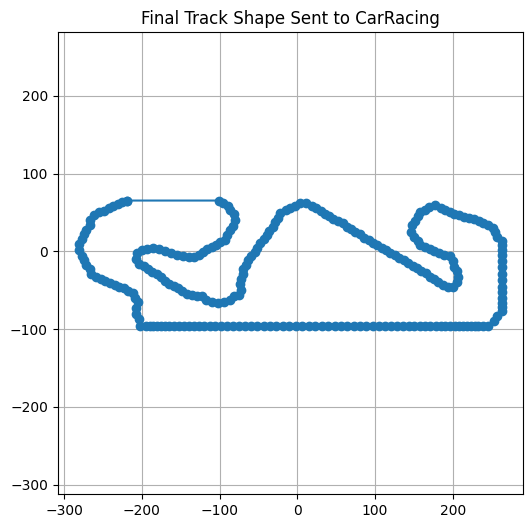

In [ ]:
# Custom Gymnasium environment with fixed track
import gymnasium as gym
from gymnasium.envs.box2d import CarRacing
from gymnasium.envs.registration import register
import numpy as np
from stable_baselines3 import SAC
from Box2D.b2 import fixtureDef, polygonShape
import math


# Load TRACK_POINTS
with open("montmelo_track.pkl", "rb") as f:
    TRACK_POINTS = pickle.load(f)


# Convert TRACK_POINTS to (alpha, beta, x, y)

track = [(alpha, beta, x, y) for (alpha, beta, x, y) in TRACK_POINTS]


import matplotlib.pyplot as plt

# Unpack and plot the shape from `track`
xs = [x for _, _, x, y in track]
ys = [y for _, _, x, y in track]

plt.figure(figsize=(6, 6))
plt.plot(xs, ys, marker='o')
plt.title("Final Track Shape Sent to CarRacing")
plt.axis("equal")
plt.grid(True)
plt.show()
#-------------------------------------



In [ ]:
# subclass with circuit creation

class MontmeloCarRacing(CarRacing):
    def _create_track(self, debug=False):
        TRACK_WIDTH = 8.0  # Adjustable
        BORDER = 0.5 # Adjustable

        self.road = []
        self.road_poly = []

        self.track = track  # your (alpha, beta, x, y) list

        if debug:
            print(f"Track has {len(self.track)} points")
            print("First few track points:")
            for i in range(min(5, len(self.track))):
                print(f"  {self.track[i]}")

        for i in range(len(self.track)):
            alpha1, beta1, x1, y1 = self.track[i]
            alpha2, beta2, x2, y2 = self.track[(i + 1) % len(self.track)]

            road1_l = (x1 - TRACK_WIDTH * np.cos(beta1), y1 - TRACK_WIDTH * np.sin(beta1))
            road1_r = (x1 + TRACK_WIDTH * np.cos(beta1), y1 + TRACK_WIDTH * np.sin(beta1))
            road2_l = (x2 - TRACK_WIDTH * np.cos(beta2), y2 - TRACK_WIDTH * np.sin(beta2))
            road2_r = (x2 + TRACK_WIDTH * np.cos(beta2), y2 + TRACK_WIDTH * np.sin(beta2))

            vertices = [road1_l, road1_r, road2_r, road2_l]

            # Debug check for invalid shapes
            if any(np.isnan(coord) for v in vertices for coord in v):
                if debug:
                    print(f"Skipping invalid tile at index {i}: {vertices}")
                continue

            self.fd_tile.shape.vertices = vertices
            t = self.world.CreateStaticBody(fixtures=self.fd_tile)
            t.userData = t
            t.color = self.road_color
            t.road_visited = False
            t.road_friction = 1.0
            t.idx = i
            t.fixtures[0].sensor = True
            self.road.append(t)
            self.road_poly.append((vertices, t.color))

        return True




# Step 2: Register the new environment
register(
    id="MontmeloCarRacing-v0",
    entry_point="__main__:MontmeloCarRacing",
)

# Step 3: Load trained SAC model
model = SAC.load("sac_carracing")

# Step 4: Evaluate on the custom track
env = gym.make("MontmeloCarRacing-v0", render_mode="rgb_array")
# Correcting the arguments passed to the Car constructor
obs, _ = env.reset()

# ---------Save or show one frame for inspection-----------
#frame = env.render()

#import matplotlib.pyplot as plt
#plt.imshow(frame)
#plt.axis("off")
#plt.title("First frame: Debug track layout")
#plt.show()

#env.close()




#------------------------------------------------
done = False
frames = []
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, _ = env.step(action)
    frame = env.render()
    frames.append(frame)
    done = terminated or truncated

env.close()

# Step 5: Save the video
import imageio
video_path = "/content/sac_montmelo.mp4"
imageio.mimsave(video_path, [np.array(f) for f in frames], fps=30)


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment MontmeloCarRacing-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 55.32GB > 1.61GB
  warnings.warn(


In [ ]:
# Step 6: Download the video
files.download(video_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>